In [1]:
%load_ext autoreload
%autoreload 2

In [9]:
import secretflow as sf

# Check the version of your SecretFlow
print("The version of SecretFlow: {}".format(sf.__version__))

# In case you have a running secretflow runtime already.
sf.shutdown()

sf.init(["alice", "bob", "charlie"], address="local")
alice, bob, charlie = sf.PYU("alice"), sf.PYU("bob"), sf.PYU("charlie")

The version of SecretFlow: 1.3.0.dev20231219


2024-01-18 11:17:41,820	INFO worker.py:1538 -- Started a local Ray instance.


In [10]:
from secretflow.ml.nn.utils import BaseModule, TorchModel
from secretflow.ml.nn.fl.utils import metric_wrapper, optim_wrapper
from secretflow.ml.nn import FLModel
from torchmetrics import Accuracy, Precision
from secretflow.security.aggregation import SecureAggregator
from torch import nn, optim

使用的数据集： MNIST, CIFAR-10, CIFAR-100, EMNIST子集： EMNIST-L
使用的模型： 对 MNIST 和 EMNIST-L 使用具有 2 个隐藏层的全连接神经网络架构。 各层神经元数量分别为200和100；MNIST和EMNIST-L模型的测试准确率分别达到98.4%和95.0%。对于 CIFAR-10 和 CIFAR-100，我们使用 CNN 模型，由 2 个带有 64 个 5 × 5 滤波器的卷积层组成，后跟 2 个带有 394 和 192 个神经元的全连接层，以及一个 softmax 层。该模型对CIFAR-10和CIFAR-100的测试精度分别为85.2%和55.3%。
下面使用的模型与原文模型略有不同，结果也略有不同。

In [11]:
class MNIST_Model(BaseModule):
    def __init__(self):
        super(MNIST_Model, self).__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(1),
            nn.Linear(784, 200),
            nn.ReLU(),
            nn.Linear(200, 100),
            nn.ReLU(),
        )
        self.head = nn.Linear(100, 10)

    def forward(self, x):
        x = self.encoder(x)
        x = self.head(x)
        return x


class EMNISTL_Model(BaseModule):
    def __init__(self):
        super(EMNISTL_Model, self).__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(1),
            nn.Linear(784, 200),
            nn.ReLU(),
            nn.Linear(200, 100),
            nn.ReLU(),
        )
        self.head = nn.Linear(100, 26)

    def forward(self, x):
        x = self.encoder(x)
        x = self.head(x)
        return x

In [12]:
from typing import Dict, List, Tuple, Union
import numpy as np

from secretflow.data.ndarray import FedNdarray, PartitionWay
from secretflow.device.device.pyu import PYU


def _convert_to_fedndarray(
    dataloader, parts, is_torch, num_classes_per_client, class_num
):
    data_list = []
    label_list = []
    for data, label in dataloader:
        if is_torch:
            data = data.numpy()
            label = label.numpy()
        data_list.append(data)
        label_list.append(label)
    data_list, label_list = np.concatenate(data_list), np.concatenate(label_list)
    return create_ndarray(
        data_list,
        label_list,
        parts=parts,
        is_torch=is_torch,
        num_classes_per_client=num_classes_per_client,
        class_num=class_num,
    )


def create_ndarray(
    data, labels, parts, is_torch=False, num_classes_per_client=4, class_num=10
):  # class_num 为数据集的分类类别数
    assert len(data) == len(labels), "Data and labels must have the same length"
    class_indices = {
        i: np.where(labels == i + min(labels))[0] for i in range(class_num)
    }
    # 分配给每个 PYU 的类别
    pyu_classes = {}
    total_samples = len(data)
    for idx, pyu in enumerate(parts.keys()):
        np.random.seed(idx)
        pyu_classes[pyu] = np.random.choice(
            class_num, num_classes_per_client, replace=False
        )

    # 分配数据和标签给每个 PYU
    pyu_data = {}
    pyu_labels = {}
    for pyu, proportion in parts.items():
        pyu_sample_size = int(total_samples * proportion)  # 计算每个 PYU 的样本量
        # 为每个 PYU 从选定的类别中采样数据
        indices = np.concatenate(
            [
                np.random.choice(
                    class_indices[cls],
                    size=pyu_sample_size // num_classes_per_client,
                    replace=True,
                )
                for cls in pyu_classes[pyu]
            ]
        )
        np.random.shuffle(indices)  # 打乱索引
        pyu_data[pyu] = data[indices]
        pyu_labels[pyu] = labels[indices]
        print(
            len(pyu_data[pyu]), pyu_classes[pyu], pyu_labels[pyu][0]
        )  # 打印每个PYU的数据量和随机类别

    # 将数据和标签转换为 FedNdarray
    data_fedndarray = FedNdarray(
        partitions={pyu: pyu(lambda arr: arr)(pyu_data[pyu]) for pyu in parts.keys()},
        partition_way=PartitionWay.HORIZONTAL,
    )
    labels_fedndarray = FedNdarray(
        partitions={pyu: pyu(lambda arr: arr)(pyu_labels[pyu]) for pyu in parts.keys()},
        partition_way=PartitionWay.HORIZONTAL,
    )

    return data_fedndarray, labels_fedndarray

In [13]:
from torchvision.datasets import MNIST, EMNIST, CIFAR10, CIFAR100
from torchvision import transforms
from torch.utils.data import DataLoader


def load_mnist(  # 共有 70000 张， 10 类，60000个训练样本和10000个测试样本
    parts: Union[List[PYU], Dict[PYU, Union[float, Tuple]]],
    batch_size: int = 1,
    is_torch: bool = True,
    num_classes_per_client=4,
    class_num=10,
) -> Tuple[Tuple[FedNdarray, FedNdarray], Tuple[FedNdarray, FedNdarray]]:
    """Load MNIST dataset to federated ndarrays.

    Args:
        parts: the data partitions.
        batch_size: Batch size for the DataLoader.
        is_torch: optional, return torch tensors if True. Default to True.
        num_classes_per_client: the random classes number of per client.
        class_num: the number of dataset categories

    Returns:
        A tuple consists of two tuples, (x_train, y_train) and (x_test, y_test).
    """
    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
    )

    # 加载 EMNIST 训练集和测试集
    trainset = MNIST(root="./data", train=True, download=True, transform=transform)
    testset = MNIST(root="./data", train=False, download=True, transform=transform)
    # EMNIST 数据集主要分为6类：By_Class, By_Merge, Balanced, Digits, Letters, MNIST，其中 MNIST 部分数据较少，共70000张10个子类数据
    # 这里使用的是 EMNIST 数据集中的MNIST部分，原论文未对数据集细节进行描述，大概率是使用的整个EMNIST数据集，因此准确率会较低

    # 使用 DataLoader 进行批处理
    trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
    testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

    # 将 DataLoader 转换为 SecretFlow 可处理的格式
    # 注意: 这里需要根据 SecretFlow 的要求进行适当的转换
    train_data, train_labels = _convert_to_fedndarray(
        trainloader, parts, is_torch, num_classes_per_client, class_num
    )
    test_data, test_labels = _convert_to_fedndarray(
        testloader, parts, is_torch, num_classes_per_client, class_num
    )

    return ((train_data, train_labels), (test_data, test_labels))


def load_emnist_L(  # 共 103600 张，37 类，每一类包含相同数据，每一类训练集 2400 张，测试集 400 张
    parts: Union[List[PYU], Dict[PYU, Union[float, Tuple]]],
    batch_size: int = 1,
    is_torch: bool = True,
    num_classes_per_client=4,
    class_num=26,
) -> Tuple[Tuple[FedNdarray, FedNdarray], Tuple[FedNdarray, FedNdarray]]:
    """Load EMNIST dataset to federated ndarrays.

    Args:
        parts: the data partitions.
        batch_size: Batch size for the DataLoader.
        is_torch: optional, return torch tensors if True. Default to True.
        num_classes_per_client: the random classes number of per client.
        class_num: the number of dataset categories

    Returns:
        A tuple consists of two tuples, (x_train, y_train) and (x_test, y_test).
    """
    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
    )

    # 加载 EMNIST 训练集和测试集
    trainset = EMNIST(
        root="./data", train=True, split="letters", download=True, transform=transform
    )
    testset = EMNIST(
        root="./data", train=False, split="letters", download=True, transform=transform
    )
    # EMNIST 数据集主要分为6类：By_Class, By_Merge, Balanced, Digits, Letters, MNIST

    # 使用 DataLoader 进行批处理
    trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
    testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

    # 将 DataLoader 转换为 SecretFlow 可处理的格式
    # 注意: 这里需要根据 SecretFlow 的要求进行适当的转换
    train_data, train_labels = _convert_to_fedndarray(
        trainloader, parts, is_torch, num_classes_per_client, class_num
    )
    test_data, test_labels = _convert_to_fedndarray(
        testloader, parts, is_torch, num_classes_per_client, class_num
    )

    return ((train_data, train_labels), (test_data, test_labels))

## 在这里修改要使用的数据集

In [14]:
load_data = {0: load_mnist, 1: load_emnist_L}
model = {0: MNIST_Model, 1: EMNISTL_Model}
num_classes = {0: 10, 1: 26, 2: 10, 3: 100}
# i = 0 # 使用 MNIST
i = 1  # 使用 EMNIST-L
(train_data, train_label), (test_data, test_label) = load_data[i](
    parts={alice: 0.1, bob: 0.1},
    is_torch=True,
)

100%|██████████| 561753746/561753746 [00:48<00:00, 11654922.20it/s]


Extracting ./data/EMNIST/raw/gzip.zip to ./data/EMNIST/raw
12480 [ 2 20 14 17] 18
12480 [18 13 17  3] 4
2080 [ 2 20 14 17] 21
2080 [18 13 17  3] 18


In [15]:
loss_fn = nn.CrossEntropyLoss
optim_fn = optim_wrapper(optim.SGD, lr=0.01)
model_def = TorchModel(
    model_fn=model[i],
    loss_fn=loss_fn,
    optim_fn=optim_fn,
    metrics=[
        metric_wrapper(
            Accuracy, task="multiclass", num_classes=num_classes[i], average="micro"
        ),
        metric_wrapper(
            Precision, task="multiclass", num_classes=num_classes[i], average="micro"
        ),
    ],
)
device_list = [alice, bob]
server = charlie
aggregator = SecureAggregator(server, [alice, bob])

INFO:root:Create proxy actor <class 'secretflow.security.aggregation.secure_aggregator._Masker'> with party alice.
INFO:root:Create proxy actor <class 'secretflow.security.aggregation.secure_aggregator._Masker'> with party bob.


In [16]:
# spcify params
fl_model = FLModel(
    server=server,
    device_list=device_list,
    model=model_def,
    aggregator=aggregator,
    strategy="fed_dyn",
    backend="torch",
)
history = fl_model.fit(
    train_data,
    train_label,
    validation_data=(test_data, test_label),
    epochs=20,
    batch_size=128,
    aggregate_freq=10,
)

INFO:root:Create proxy actor <class 'secretflow.ml.nn.fl.backend.torch.strategy.fed_dyn.PYUFedDYN'> with party alice.
INFO:root:Create proxy actor <class 'secretflow.ml.nn.fl.backend.torch.strategy.fed_dyn.PYUFedDYN'> with party bob.
INFO:root:FL Train Params: {'x': FedNdarray(partitions={PYURuntime(alice): <secretflow.device.device.pyu.PYUObject object at 0x7f2654319580>, PYURuntime(bob): <secretflow.device.device.pyu.PYUObject object at 0x7f26542f1b80>}, partition_way=<PartitionWay.HORIZONTAL: 'horizontal'>), 'y': FedNdarray(partitions={PYURuntime(alice): <secretflow.device.device.pyu.PYUObject object at 0x7f26540cb940>, PYURuntime(bob): <secretflow.device.device.pyu.PYUObject object at 0x7f26542fcc70>}, partition_way=<PartitionWay.HORIZONTAL: 'horizontal'>), 'batch_size': 128, 'batch_sampling_rate': None, 'epochs': 20, 'verbose': 1, 'callbacks': None, 'validation_data': (FedNdarray(partitions={PYURuntime(alice): <secretflow.device.device.pyu.PYUObject object at 0x7f29d8402610>, PYUR

Epoch 1/20


Train Processing: :  92%|█████████▏| 90/98 [00:00<00:00, 192.35it/s]/home/cyf/anaconda3/envs/sf/lib/python3.8/site-packages/secretflow/ml/nn/metrics.py:59: UserWarning: Please pay attention to local metrics, global only do naive aggregation.
  warnings.warn(
2024-01-18 11:19:11.306214: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-01-18 11:19:11.306279: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2024-01-18 11:19:11.306321: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2024-01-18 11:19

Epoch 2/20
(PYUFedDYN pid=26127) {'train-loss': 4.188660144805908, 'train_multiclassaccuracy': tensor(0.2453), 'train_multiclassprecision': tensor(0.2453), 'val_eval_multiclassaccuracy': tensor(0.2500), 'val_eval_multiclassprecision': tensor(0.2500)}
(PYUFedDYN pid=26129) {'train-loss': 3.3802225589752197, 'train_multiclassaccuracy': tensor(0.2738), 'train_multiclassprecision': tensor(0.2738), 'val_eval_multiclassaccuracy': tensor(0.2500), 'val_eval_multiclassprecision': tensor(0.2500)}


Train Processing: :  10%|█         | 10/98 [00:00<00:01, 83.95it/s]

Epoch 3/20
(PYUFedDYN pid=26127) {'train-loss': 2.693168878555298, 'train_multiclassaccuracy': tensor(0.2668), 'train_multiclassprecision': tensor(0.2668), 'val_eval_multiclassaccuracy': tensor(0.2500), 'val_eval_multiclassprecision': tensor(0.2500)}
(PYUFedDYN pid=26129) {'train-loss': 3.0264475345611572, 'train_multiclassaccuracy': tensor(0.2939), 'train_multiclassprecision': tensor(0.2939), 'val_eval_multiclassaccuracy': tensor(0.2500), 'val_eval_multiclassprecision': tensor(0.2500)}


Train Processing: :  20%|██        | 20/98 [00:00<00:00, 133.64it/s]

Epoch 4/20
(PYUFedDYN pid=26127) {'train-loss': 1.97638738155365, 'train_multiclassaccuracy': tensor(0.4095), 'train_multiclassprecision': tensor(0.4095), 'val_eval_multiclassaccuracy': tensor(0.2510), 'val_eval_multiclassprecision': tensor(0.2510)}
(PYUFedDYN pid=26129) {'train-loss': 2.3286216259002686, 'train_multiclassaccuracy': tensor(0.4348), 'train_multiclassprecision': tensor(0.4348), 'val_eval_multiclassaccuracy': tensor(0.3091), 'val_eval_multiclassprecision': tensor(0.3091)}


Train Processing: :  20%|██        | 20/98 [00:00<00:00, 147.45it/s]

Epoch 5/20
(PYUFedDYN pid=26127) {'train-loss': 1.737599492073059, 'train_multiclassaccuracy': tensor(0.5082), 'train_multiclassprecision': tensor(0.5082), 'val_eval_multiclassaccuracy': tensor(0.3947), 'val_eval_multiclassprecision': tensor(0.3947)}
(PYUFedDYN pid=26129) {'train-loss': 2.1899924278259277, 'train_multiclassaccuracy': tensor(0.5569), 'train_multiclassprecision': tensor(0.5569), 'val_eval_multiclassaccuracy': tensor(0.5072), 'val_eval_multiclassprecision': tensor(0.5072)}


Train Processing: :  20%|██        | 20/98 [00:00<00:00, 152.39it/s]

Epoch 6/20
(PYUFedDYN pid=26127) {'train-loss': 1.602935791015625, 'train_multiclassaccuracy': tensor(0.5999), 'train_multiclassprecision': tensor(0.5999), 'val_eval_multiclassaccuracy': tensor(0.5500), 'val_eval_multiclassprecision': tensor(0.5500)}
(PYUFedDYN pid=26129) {'train-loss': 2.0463671684265137, 'train_multiclassaccuracy': tensor(0.6533), 'train_multiclassprecision': tensor(0.6533), 'val_eval_multiclassaccuracy': tensor(0.5808), 'val_eval_multiclassprecision': tensor(0.5808)}


Train Processing: :  20%|██        | 20/98 [00:00<00:00, 158.94it/s]

Epoch 7/20
(PYUFedDYN pid=26127) {'train-loss': 1.5582889318466187, 'train_multiclassaccuracy': tensor(0.6999), 'train_multiclassprecision': tensor(0.6999), 'val_eval_multiclassaccuracy': tensor(0.6365), 'val_eval_multiclassprecision': tensor(0.6365)}
(PYUFedDYN pid=26129) {'train-loss': 1.9253712892532349, 'train_multiclassaccuracy': tensor(0.7143), 'train_multiclassprecision': tensor(0.7143), 'val_eval_multiclassaccuracy': tensor(0.6562), 'val_eval_multiclassprecision': tensor(0.6562)}


Train Processing: :  20%|██        | 20/98 [00:00<00:00, 152.97it/s]

Epoch 8/20
(PYUFedDYN pid=26127) {'train-loss': 1.528643250465393, 'train_multiclassaccuracy': tensor(0.7719), 'train_multiclassprecision': tensor(0.7719), 'val_eval_multiclassaccuracy': tensor(0.6822), 'val_eval_multiclassprecision': tensor(0.6822)}
(PYUFedDYN pid=26129) {'train-loss': 1.8104336261749268, 'train_multiclassaccuracy': tensor(0.7633), 'train_multiclassprecision': tensor(0.7633), 'val_eval_multiclassaccuracy': tensor(0.7212), 'val_eval_multiclassprecision': tensor(0.7212)}


Train Processing: :  20%|██        | 20/98 [00:00<00:00, 155.90it/s]

Epoch 9/20
(PYUFedDYN pid=26127) {'train-loss': 1.35989511013031, 'train_multiclassaccuracy': tensor(0.8200), 'train_multiclassprecision': tensor(0.8200), 'val_eval_multiclassaccuracy': tensor(0.7192), 'val_eval_multiclassprecision': tensor(0.7192)}
(PYUFedDYN pid=26129) {'train-loss': 1.7463831901550293, 'train_multiclassaccuracy': tensor(0.8008), 'train_multiclassprecision': tensor(0.8008), 'val_eval_multiclassaccuracy': tensor(0.7620), 'val_eval_multiclassprecision': tensor(0.7620)}


Train Processing: :  20%|██        | 20/98 [00:00<00:00, 158.38it/s]

Epoch 10/20
(PYUFedDYN pid=26127) {'train-loss': 1.1803752183914185, 'train_multiclassaccuracy': tensor(0.8457), 'train_multiclassprecision': tensor(0.8457), 'val_eval_multiclassaccuracy': tensor(0.7418), 'val_eval_multiclassprecision': tensor(0.7418)}
(PYUFedDYN pid=26129) {'train-loss': 1.6760706901550293, 'train_multiclassaccuracy': tensor(0.8261), 'train_multiclassprecision': tensor(0.8261), 'val_eval_multiclassaccuracy': tensor(0.7808), 'val_eval_multiclassprecision': tensor(0.7808)}


Train Processing: :  20%|██        | 20/98 [00:00<00:00, 149.71it/s]

Epoch 11/20
(PYUFedDYN pid=26127) {'train-loss': 1.0429139137268066, 'train_multiclassaccuracy': tensor(0.8603), 'train_multiclassprecision': tensor(0.8603), 'val_eval_multiclassaccuracy': tensor(0.7596), 'val_eval_multiclassprecision': tensor(0.7596)}
(PYUFedDYN pid=26129) {'train-loss': 1.5609221458435059, 'train_multiclassaccuracy': tensor(0.8413), 'train_multiclassprecision': tensor(0.8413), 'val_eval_multiclassaccuracy': tensor(0.8005), 'val_eval_multiclassprecision': tensor(0.8005)}


Train Processing: :  20%|██        | 20/98 [00:00<00:00, 153.16it/s]

Epoch 12/20
(PYUFedDYN pid=26127) {'train-loss': 0.9109519124031067, 'train_multiclassaccuracy': tensor(0.8726), 'train_multiclassprecision': tensor(0.8726), 'val_eval_multiclassaccuracy': tensor(0.7726), 'val_eval_multiclassprecision': tensor(0.7726)}
(PYUFedDYN pid=26129) {'train-loss': 1.4293018579483032, 'train_multiclassaccuracy': tensor(0.8515), 'train_multiclassprecision': tensor(0.8515), 'val_eval_multiclassaccuracy': tensor(0.8106), 'val_eval_multiclassprecision': tensor(0.8106)}


Train Processing: :  20%|██        | 20/98 [00:00<00:00, 154.91it/s]

Epoch 13/20
(PYUFedDYN pid=26127) {'train-loss': 0.794434666633606, 'train_multiclassaccuracy': tensor(0.8778), 'train_multiclassprecision': tensor(0.8778), 'val_eval_multiclassaccuracy': tensor(0.7812), 'val_eval_multiclassprecision': tensor(0.7812)}
(PYUFedDYN pid=26129) {'train-loss': 1.3041919469833374, 'train_multiclassaccuracy': tensor(0.8593), 'train_multiclassprecision': tensor(0.8593), 'val_eval_multiclassaccuracy': tensor(0.8197), 'val_eval_multiclassprecision': tensor(0.8197)}


Train Processing: :  20%|██        | 20/98 [00:00<00:00, 156.04it/s]

Epoch 14/20
(PYUFedDYN pid=26127) {'train-loss': 0.6926169991493225, 'train_multiclassaccuracy': tensor(0.8838), 'train_multiclassprecision': tensor(0.8838), 'val_eval_multiclassaccuracy': tensor(0.7861), 'val_eval_multiclassprecision': tensor(0.7861)}
(PYUFedDYN pid=26129) {'train-loss': 1.1841453313827515, 'train_multiclassaccuracy': tensor(0.8661), 'train_multiclassprecision': tensor(0.8661), 'val_eval_multiclassaccuracy': tensor(0.8250), 'val_eval_multiclassprecision': tensor(0.8250)}


Train Processing: :  20%|██        | 20/98 [00:00<00:00, 154.61it/s]

Epoch 15/20
(PYUFedDYN pid=26127) {'train-loss': 0.5987633466720581, 'train_multiclassaccuracy': tensor(0.8878), 'train_multiclassprecision': tensor(0.8878), 'val_eval_multiclassaccuracy': tensor(0.7899), 'val_eval_multiclassprecision': tensor(0.7899)}
(PYUFedDYN pid=26129) {'train-loss': 1.0679750442504883, 'train_multiclassaccuracy': tensor(0.8724), 'train_multiclassprecision': tensor(0.8724), 'val_eval_multiclassaccuracy': tensor(0.8341), 'val_eval_multiclassprecision': tensor(0.8341)}


Train Processing: :  20%|██        | 20/98 [00:00<00:00, 153.02it/s]

Epoch 16/20
(PYUFedDYN pid=26127) {'train-loss': 0.509560227394104, 'train_multiclassaccuracy': tensor(0.8925), 'train_multiclassprecision': tensor(0.8925), 'val_eval_multiclassaccuracy': tensor(0.7971), 'val_eval_multiclassprecision': tensor(0.7971)}
(PYUFedDYN pid=26129) {'train-loss': 0.9591097831726074, 'train_multiclassaccuracy': tensor(0.8784), 'train_multiclassprecision': tensor(0.8784), 'val_eval_multiclassaccuracy': tensor(0.8418), 'val_eval_multiclassprecision': tensor(0.8418)}


Train Processing: :  20%|██        | 20/98 [00:00<00:00, 145.71it/s]

Epoch 17/20
(PYUFedDYN pid=26127) {'train-loss': 0.4320308268070221, 'train_multiclassaccuracy': tensor(0.8954), 'train_multiclassprecision': tensor(0.8954), 'val_eval_multiclassaccuracy': tensor(0.7995), 'val_eval_multiclassprecision': tensor(0.7995)}
(PYUFedDYN pid=26129) {'train-loss': 0.8596035242080688, 'train_multiclassaccuracy': tensor(0.8821), 'train_multiclassprecision': tensor(0.8821), 'val_eval_multiclassaccuracy': tensor(0.8490), 'val_eval_multiclassprecision': tensor(0.8490)}


Train Processing: :  92%|█████████▏| 90/98 [00:01<00:00, 78.61it/s, {'multiclassaccuracy': 0.89210737, 'multiclassprecision': 0.89210737, 'val_multiclassaccuracy': 0.8278846, 'val_multiclassprecision': 0.8278846}] 


(PYUFedDYN pid=26127) {'train-loss': 0.36131522059440613, 'train_multiclassaccuracy': tensor(0.8981), 'train_multiclassprecision': tensor(0.8981), 'val_eval_multiclassaccuracy': tensor(0.8038), 'val_eval_multiclassprecision': tensor(0.8038)}


Train Processing: :  20%|██        | 20/98 [00:00<00:00, 155.20it/s]

Epoch 18/20
(PYUFedDYN pid=26129) {'train-loss': 0.7573780417442322, 'train_multiclassaccuracy': tensor(0.8861), 'train_multiclassprecision': tensor(0.8861), 'val_eval_multiclassaccuracy': tensor(0.8519), 'val_eval_multiclassprecision': tensor(0.8519)}


Train Processing: :  20%|██        | 20/98 [00:00<00:00, 144.82it/s]

Epoch 19/20
(PYUFedDYN pid=26127) {'train-loss': 0.28467482328414917, 'train_multiclassaccuracy': tensor(0.8989), 'train_multiclassprecision': tensor(0.8989), 'val_eval_multiclassaccuracy': tensor(0.8058), 'val_eval_multiclassprecision': tensor(0.8058)}
(PYUFedDYN pid=26129) {'train-loss': 0.6594139337539673, 'train_multiclassaccuracy': tensor(0.8892), 'train_multiclassprecision': tensor(0.8892), 'val_eval_multiclassaccuracy': tensor(0.8543), 'val_eval_multiclassprecision': tensor(0.8543)}


Train Processing: :  20%|██        | 20/98 [00:00<00:00, 155.23it/s]

Epoch 20/20
(PYUFedDYN pid=26127) {'train-loss': 0.2140738070011139, 'train_multiclassaccuracy': tensor(0.9009), 'train_multiclassprecision': tensor(0.9009), 'val_eval_multiclassaccuracy': tensor(0.8067), 'val_eval_multiclassprecision': tensor(0.8067)}
(PYUFedDYN pid=26129) {'train-loss': 0.5597807168960571, 'train_multiclassaccuracy': tensor(0.8928), 'train_multiclassprecision': tensor(0.8928), 'val_eval_multiclassaccuracy': tensor(0.8577), 'val_eval_multiclassprecision': tensor(0.8577)}


Train Processing: :  92%|█████████▏| 90/98 [00:01<00:00, 64.83it/s, {'multiclassaccuracy': 0.8985977, 'multiclassprecision': 0.8985977, 'val_multiclassaccuracy': 0.8375, 'val_multiclassprecision': 0.8375}] 


In [17]:
print(history["local_history"])

{'alice_train-loss': [4.188660144805908, 2.693168878555298, 1.97638738155365, 1.737599492073059, 1.602935791015625, 1.5582889318466187, 1.528643250465393, 1.35989511013031, 1.1803752183914185, 1.0429139137268066, 0.9109519124031067, 0.794434666633606, 0.6926169991493225, 0.5987633466720581, 0.509560227394104, 0.4320308268070221, 0.36131522059440613, 0.28467482328414917, 0.2140738070011139, 0.14483265578746796], 'alice_train_multiclassaccuracy': [tensor(0.2453), tensor(0.2668), tensor(0.4095), tensor(0.5082), tensor(0.5999), tensor(0.6999), tensor(0.7719), tensor(0.8200), tensor(0.8457), tensor(0.8603), tensor(0.8726), tensor(0.8778), tensor(0.8838), tensor(0.8878), tensor(0.8925), tensor(0.8954), tensor(0.8981), tensor(0.8989), tensor(0.9009), tensor(0.9019)], 'alice_train_multiclassprecision': [tensor(0.2453), tensor(0.2668), tensor(0.4095), tensor(0.5082), tensor(0.5999), tensor(0.6999), tensor(0.7719), tensor(0.8200), tensor(0.8457), tensor(0.8603), tensor(0.8726), tensor(0.8778), t

(PYUFedDYN pid=26127) {'train-loss': 0.14483265578746796, 'train_multiclassaccuracy': tensor(0.9019), 'train_multiclassprecision': tensor(0.9019), 'val_eval_multiclassaccuracy': tensor(0.8101), 'val_eval_multiclassprecision': tensor(0.8101)}
(PYUFedDYN pid=26129) {'train-loss': 0.4651905596256256, 'train_multiclassaccuracy': tensor(0.8953), 'train_multiclassprecision': tensor(0.8953), 'val_eval_multiclassaccuracy': tensor(0.8649), 'val_eval_multiclassprecision': tensor(0.8649)}


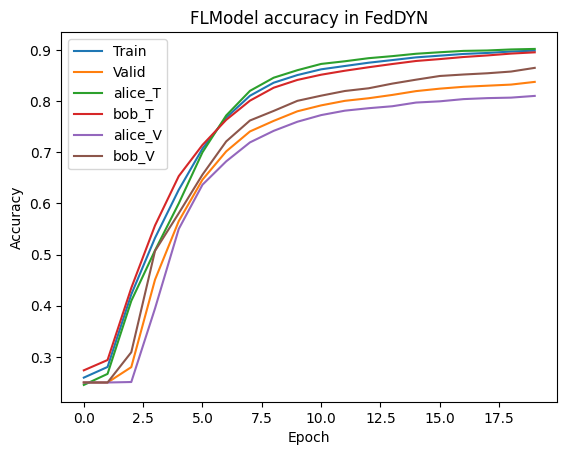

In [18]:
from matplotlib import pyplot as plt

# Draw accuracy values for training & validation
plt.plot(history["global_history"]["multiclassaccuracy"])
plt.plot(history["global_history"]["val_multiclassaccuracy"])
plt.plot(history["local_history"]["alice_train_multiclassaccuracy"])
plt.plot(history["local_history"]["bob_train_multiclassaccuracy"])
plt.plot(history["local_history"]["alice_val_eval_multiclassaccuracy"])
plt.plot(history["local_history"]["bob_val_eval_multiclassaccuracy"])
plt.title("FLModel accuracy in FedDYN")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train", "Valid", "alice_T", "bob_T", "alice_V", "bob_V"], loc="upper left")
plt.show()

In [19]:
fl_model_2 = FLModel(
    server=server,
    device_list=device_list,
    model=model_def,
    aggregator=aggregator,
    strategy="fed_avg_w",  # fl strategy
    backend="torch",  # backend support ['tensorflow', 'torch']
)
history_2 = fl_model.fit(
    train_data,
    train_label,
    validation_data=(test_data, test_label),
    epochs=20,
    batch_size=128,
    aggregate_freq=10,
)

INFO:root:Create proxy actor <class 'secretflow.ml.nn.fl.backend.torch.strategy.fed_avg_w.PYUFedAvgW'> with party alice.
INFO:root:Create proxy actor <class 'secretflow.ml.nn.fl.backend.torch.strategy.fed_avg_w.PYUFedAvgW'> with party bob.
INFO:root:FL Train Params: {'x': FedNdarray(partitions={PYURuntime(alice): <secretflow.device.device.pyu.PYUObject object at 0x7f2654319580>, PYURuntime(bob): <secretflow.device.device.pyu.PYUObject object at 0x7f26542f1b80>}, partition_way=<PartitionWay.HORIZONTAL: 'horizontal'>), 'y': FedNdarray(partitions={PYURuntime(alice): <secretflow.device.device.pyu.PYUObject object at 0x7f26540cb940>, PYURuntime(bob): <secretflow.device.device.pyu.PYUObject object at 0x7f26542fcc70>}, partition_way=<PartitionWay.HORIZONTAL: 'horizontal'>), 'batch_size': 128, 'batch_sampling_rate': None, 'epochs': 20, 'verbose': 1, 'callbacks': None, 'validation_data': (FedNdarray(partitions={PYURuntime(alice): <secretflow.device.device.pyu.PYUObject object at 0x7f29d8402610>

Epoch 1/20


Train Processing: :  92%|█████████▏| 90/98 [00:00<00:00, 174.43it/s]/home/cyf/anaconda3/envs/sf/lib/python3.8/site-packages/secretflow/ml/nn/metrics.py:59: UserWarning: Please pay attention to local metrics, global only do naive aggregation.
  warnings.warn(
(pid=1109) 2024-01-18 11:19:38.695813: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
(pid=1111) 2024-01-18 11:19:38.722866: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
(pid=1109) 2024-01-18 11:19:39.193383: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such f

Epoch 2/20
(PYUFedDYN pid=26127) {'train-loss': 0.08044049888849258, 'train_multiclassaccuracy': tensor(0.9034), 'train_multiclassprecision': tensor(0.9034), 'val_eval_multiclassaccuracy': tensor(0.8139), 'val_eval_multiclassprecision': tensor(0.8139)}
(PYUFedDYN pid=26129) {'train-loss': 0.3673584759235382, 'train_multiclassaccuracy': tensor(0.8964), 'train_multiclassprecision': tensor(0.8964), 'val_eval_multiclassaccuracy': tensor(0.8663), 'val_eval_multiclassprecision': tensor(0.8663)}


Train Processing: :  20%|██        | 20/98 [00:00<00:00, 150.88it/s]

Epoch 3/20
(PYUFedDYN pid=26127) {'train-loss': 0.014227005653083324, 'train_multiclassaccuracy': tensor(0.9042), 'train_multiclassprecision': tensor(0.9042), 'val_eval_multiclassaccuracy': tensor(0.8149), 'val_eval_multiclassprecision': tensor(0.8149)}
(PYUFedDYN pid=26129) {'train-loss': 0.2703603208065033, 'train_multiclassaccuracy': tensor(0.8981), 'train_multiclassprecision': tensor(0.8981), 'val_eval_multiclassaccuracy': tensor(0.8678), 'val_eval_multiclassprecision': tensor(0.8678)}


Train Processing: :  20%|██        | 20/98 [00:00<00:00, 150.97it/s]

Epoch 4/20
(PYUFedDYN pid=26127) {'train-loss': -0.05369977653026581, 'train_multiclassaccuracy': tensor(0.9051), 'train_multiclassprecision': tensor(0.9051), 'val_eval_multiclassaccuracy': tensor(0.8178), 'val_eval_multiclassprecision': tensor(0.8178)}
(PYUFedDYN pid=26129) {'train-loss': 0.17689387500286102, 'train_multiclassaccuracy': tensor(0.9003), 'train_multiclassprecision': tensor(0.9003), 'val_eval_multiclassaccuracy': tensor(0.8687), 'val_eval_multiclassprecision': tensor(0.8687)}


Train Processing: :  20%|██        | 20/98 [00:00<00:00, 131.71it/s]

Epoch 5/20
(PYUFedDYN pid=26127) {'train-loss': -0.1212657019495964, 'train_multiclassaccuracy': tensor(0.9053), 'train_multiclassprecision': tensor(0.9053), 'val_eval_multiclassaccuracy': tensor(0.8216), 'val_eval_multiclassprecision': tensor(0.8216)}
(PYUFedDYN pid=26129) {'train-loss': 0.07915104180574417, 'train_multiclassaccuracy': tensor(0.9014), 'train_multiclassprecision': tensor(0.9014), 'val_eval_multiclassaccuracy': tensor(0.8721), 'val_eval_multiclassprecision': tensor(0.8721)}


Train Processing: :  10%|█         | 10/98 [00:00<00:00, 98.45it/s]

Epoch 6/20
(PYUFedDYN pid=26127) {'train-loss': -0.18948303163051605, 'train_multiclassaccuracy': tensor(0.9045), 'train_multiclassprecision': tensor(0.9045), 'val_eval_multiclassaccuracy': tensor(0.8245), 'val_eval_multiclassprecision': tensor(0.8245)}
(PYUFedDYN pid=26129) {'train-loss': -0.015630895271897316, 'train_multiclassaccuracy': tensor(0.9025), 'train_multiclassprecision': tensor(0.9025), 'val_eval_multiclassaccuracy': tensor(0.8707), 'val_eval_multiclassprecision': tensor(0.8707)}


Train Processing: :  20%|██        | 20/98 [00:00<00:00, 149.32it/s]

Epoch 7/20
(PYUFedDYN pid=26127) {'train-loss': -0.2650998830795288, 'train_multiclassaccuracy': tensor(0.9043), 'train_multiclassprecision': tensor(0.9043), 'val_eval_multiclassaccuracy': tensor(0.8250), 'val_eval_multiclassprecision': tensor(0.8250)}
(PYUFedDYN pid=26129) {'train-loss': -0.10920149832963943, 'train_multiclassaccuracy': tensor(0.9028), 'train_multiclassprecision': tensor(0.9028), 'val_eval_multiclassaccuracy': tensor(0.8721), 'val_eval_multiclassprecision': tensor(0.8721)}


Train Processing: :  20%|██        | 20/98 [00:00<00:00, 153.56it/s]

Epoch 8/20
(PYUFedDYN pid=26127) {'train-loss': -0.33136722445487976, 'train_multiclassaccuracy': tensor(0.9037), 'train_multiclassprecision': tensor(0.9037), 'val_eval_multiclassaccuracy': tensor(0.8288), 'val_eval_multiclassprecision': tensor(0.8288)}
(PYUFedDYN pid=26129) {'train-loss': -0.20910151302814484, 'train_multiclassaccuracy': tensor(0.9036), 'train_multiclassprecision': tensor(0.9036), 'val_eval_multiclassaccuracy': tensor(0.8736), 'val_eval_multiclassprecision': tensor(0.8736)}


Train Processing: :  20%|██        | 20/98 [00:00<00:00, 155.74it/s]

Epoch 9/20
(PYUFedDYN pid=26127) {'train-loss': -0.40967634320259094, 'train_multiclassaccuracy': tensor(0.9037), 'train_multiclassprecision': tensor(0.9037), 'val_eval_multiclassaccuracy': tensor(0.8317), 'val_eval_multiclassprecision': tensor(0.8317)}
(PYUFedDYN pid=26129) {'train-loss': -0.3022306263446808, 'train_multiclassaccuracy': tensor(0.9043), 'train_multiclassprecision': tensor(0.9043), 'val_eval_multiclassaccuracy': tensor(0.8745), 'val_eval_multiclassprecision': tensor(0.8745)}


Train Processing: :  20%|██        | 20/98 [00:00<00:00, 148.31it/s]

Epoch 10/20
(PYUFedDYN pid=26127) {'train-loss': -0.48073142766952515, 'train_multiclassaccuracy': tensor(0.9040), 'train_multiclassprecision': tensor(0.9040), 'val_eval_multiclassaccuracy': tensor(0.8327), 'val_eval_multiclassprecision': tensor(0.8327)}
(PYUFedDYN pid=26129) {'train-loss': -0.4054984748363495, 'train_multiclassaccuracy': tensor(0.9040), 'train_multiclassprecision': tensor(0.9040), 'val_eval_multiclassaccuracy': tensor(0.8736), 'val_eval_multiclassprecision': tensor(0.8736)}


Train Processing: :  20%|██        | 20/98 [00:00<00:00, 151.39it/s]

Epoch 11/20
(PYUFedDYN pid=26127) {'train-loss': -0.5630325675010681, 'train_multiclassaccuracy': tensor(0.9046), 'train_multiclassprecision': tensor(0.9046), 'val_eval_multiclassaccuracy': tensor(0.8327), 'val_eval_multiclassprecision': tensor(0.8327)}
(PYUFedDYN pid=26129) {'train-loss': -0.5046301484107971, 'train_multiclassaccuracy': tensor(0.9042), 'train_multiclassprecision': tensor(0.9042), 'val_eval_multiclassaccuracy': tensor(0.8755), 'val_eval_multiclassprecision': tensor(0.8755)}


Train Processing: :  20%|██        | 20/98 [00:00<00:00, 128.21it/s]

Epoch 12/20
(PYUFedDYN pid=26127) {'train-loss': -0.637290894985199, 'train_multiclassaccuracy': tensor(0.9049), 'train_multiclassprecision': tensor(0.9049), 'val_eval_multiclassaccuracy': tensor(0.8341), 'val_eval_multiclassprecision': tensor(0.8341)}
(PYUFedDYN pid=26129) {'train-loss': -0.5980814099311829, 'train_multiclassaccuracy': tensor(0.9042), 'train_multiclassprecision': tensor(0.9042), 'val_eval_multiclassaccuracy': tensor(0.8760), 'val_eval_multiclassprecision': tensor(0.8760)}


Train Processing: :  20%|██        | 20/98 [00:00<00:00, 153.63it/s]

Epoch 13/20
(PYUFedDYN pid=26127) {'train-loss': -0.7204365730285645, 'train_multiclassaccuracy': tensor(0.9046), 'train_multiclassprecision': tensor(0.9046), 'val_eval_multiclassaccuracy': tensor(0.8351), 'val_eval_multiclassprecision': tensor(0.8351)}
(PYUFedDYN pid=26129) {'train-loss': -0.7020918726921082, 'train_multiclassaccuracy': tensor(0.9046), 'train_multiclassprecision': tensor(0.9046), 'val_eval_multiclassaccuracy': tensor(0.8760), 'val_eval_multiclassprecision': tensor(0.8760)}


Train Processing: :  20%|██        | 20/98 [00:00<00:00, 154.64it/s]

Epoch 14/20
(PYUFedDYN pid=26127) {'train-loss': -0.7988511323928833, 'train_multiclassaccuracy': tensor(0.9041), 'train_multiclassprecision': tensor(0.9041), 'val_eval_multiclassaccuracy': tensor(0.8337), 'val_eval_multiclassprecision': tensor(0.8337)}
(PYUFedDYN pid=26129) {'train-loss': -0.8005225658416748, 'train_multiclassaccuracy': tensor(0.9046), 'train_multiclassprecision': tensor(0.9046), 'val_eval_multiclassaccuracy': tensor(0.8760), 'val_eval_multiclassprecision': tensor(0.8760)}


Train Processing: :  20%|██        | 20/98 [00:00<00:00, 150.72it/s]

Epoch 15/20
(PYUFedDYN pid=26127) {'train-loss': -0.8980284929275513, 'train_multiclassaccuracy': tensor(0.9043), 'train_multiclassprecision': tensor(0.9043), 'val_eval_multiclassaccuracy': tensor(0.8327), 'val_eval_multiclassprecision': tensor(0.8327)}
(PYUFedDYN pid=26129) {'train-loss': -0.9081017374992371, 'train_multiclassaccuracy': tensor(0.9044), 'train_multiclassprecision': tensor(0.9044), 'val_eval_multiclassaccuracy': tensor(0.8755), 'val_eval_multiclassprecision': tensor(0.8755)}


Train Processing: :  20%|██        | 20/98 [00:00<00:00, 156.32it/s]

Epoch 16/20
(PYUFedDYN pid=26127) {'train-loss': -0.9956777691841125, 'train_multiclassaccuracy': tensor(0.9043), 'train_multiclassprecision': tensor(0.9043), 'val_eval_multiclassaccuracy': tensor(0.8337), 'val_eval_multiclassprecision': tensor(0.8337)}
(PYUFedDYN pid=26129) {'train-loss': -1.00986909866333, 'train_multiclassaccuracy': tensor(0.9038), 'train_multiclassprecision': tensor(0.9038), 'val_eval_multiclassaccuracy': tensor(0.8750), 'val_eval_multiclassprecision': tensor(0.8750)}


Train Processing: :  20%|██        | 20/98 [00:00<00:00, 147.24it/s]

Epoch 17/20
(PYUFedDYN pid=26127) {'train-loss': -1.0854036808013916, 'train_multiclassaccuracy': tensor(0.9041), 'train_multiclassprecision': tensor(0.9041), 'val_eval_multiclassaccuracy': tensor(0.8308), 'val_eval_multiclassprecision': tensor(0.8308)}
(PYUFedDYN pid=26129) {'train-loss': -1.1057486534118652, 'train_multiclassaccuracy': tensor(0.9034), 'train_multiclassprecision': tensor(0.9034), 'val_eval_multiclassaccuracy': tensor(0.8769), 'val_eval_multiclassprecision': tensor(0.8769)}


Train Processing: :  20%|██        | 20/98 [00:00<00:00, 157.70it/s]

Epoch 18/20
(PYUFedDYN pid=26127) {'train-loss': -1.1910898685455322, 'train_multiclassaccuracy': tensor(0.9043), 'train_multiclassprecision': tensor(0.9043), 'val_eval_multiclassaccuracy': tensor(0.8274), 'val_eval_multiclassprecision': tensor(0.8274)}
(PYUFedDYN pid=26129) {'train-loss': -1.2148244380950928, 'train_multiclassaccuracy': tensor(0.9041), 'train_multiclassprecision': tensor(0.9041), 'val_eval_multiclassaccuracy': tensor(0.8760), 'val_eval_multiclassprecision': tensor(0.8760)}


Train Processing: :  20%|██        | 20/98 [00:00<00:00, 151.03it/s]

Epoch 19/20
(PYUFedDYN pid=26127) {'train-loss': -1.2895804643630981, 'train_multiclassaccuracy': tensor(0.9043), 'train_multiclassprecision': tensor(0.9043), 'val_eval_multiclassaccuracy': tensor(0.8293), 'val_eval_multiclassprecision': tensor(0.8293)}
(PYUFedDYN pid=26129) {'train-loss': -1.332841157913208, 'train_multiclassaccuracy': tensor(0.9042), 'train_multiclassprecision': tensor(0.9042), 'val_eval_multiclassaccuracy': tensor(0.8740), 'val_eval_multiclassprecision': tensor(0.8740)}


Train Processing: :  20%|██        | 20/98 [00:00<00:00, 149.16it/s]

Epoch 20/20
(PYUFedDYN pid=26127) {'train-loss': -1.4142484664916992, 'train_multiclassaccuracy': tensor(0.9044), 'train_multiclassprecision': tensor(0.9044), 'val_eval_multiclassaccuracy': tensor(0.8284), 'val_eval_multiclassprecision': tensor(0.8284)}
(PYUFedDYN pid=26129) {'train-loss': -1.4295871257781982, 'train_multiclassaccuracy': tensor(0.9043), 'train_multiclassprecision': tensor(0.9043), 'val_eval_multiclassaccuracy': tensor(0.8769), 'val_eval_multiclassprecision': tensor(0.8769)}


Train Processing: :  92%|█████████▏| 90/98 [00:01<00:00, 45.09it/s, {'multiclassaccuracy': 0.9043269, 'multiclassprecision': 0.9043269, 'val_multiclassaccuracy': 0.85504806, 'val_multiclassprecision': 0.85504806}] 


In [20]:
print(history_2["local_history"])

(PYUFedDYN pid=26127) {'train-loss': -1.5059984922409058, 'train_multiclassaccuracy': tensor(0.9048), 'train_multiclassprecision': tensor(0.9048), 'val_eval_multiclassaccuracy': tensor(0.8313), 'val_eval_multiclassprecision': tensor(0.8313)}
(PYUFedDYN pid=26129) {'train-loss': -1.569032907485962, 'train_multiclassaccuracy': tensor(0.9038), 'train_multiclassprecision': tensor(0.9038), 'val_eval_multiclassaccuracy': tensor(0.8788), 'val_eval_multiclassprecision': tensor(0.8788)}
{'alice_train-loss': [0.08044049888849258, 0.014227005653083324, -0.05369977653026581, -0.1212657019495964, -0.18948303163051605, -0.2650998830795288, -0.33136722445487976, -0.40967634320259094, -0.48073142766952515, -0.5630325675010681, -0.637290894985199, -0.7204365730285645, -0.7988511323928833, -0.8980284929275513, -0.9956777691841125, -1.0854036808013916, -1.1910898685455322, -1.2895804643630981, -1.4142484664916992, -1.5059984922409058], 'alice_train_multiclassaccuracy': [tensor(0.9034), tensor(0.9042), te

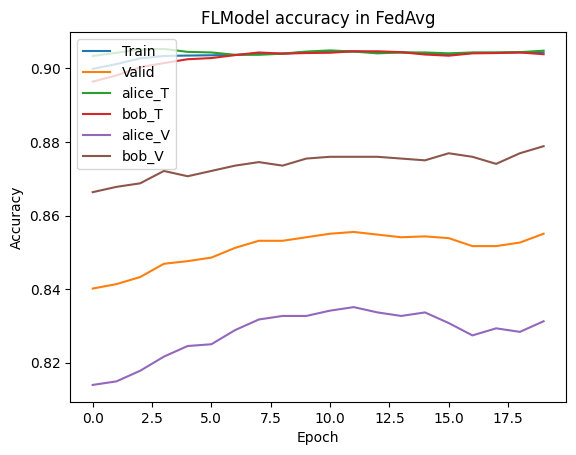

In [21]:
from matplotlib import pyplot as plt

# Draw accuracy values for training & validation
plt.plot(history_2["global_history"]["multiclassaccuracy"])
plt.plot(history_2["global_history"]["val_multiclassaccuracy"])
plt.plot(history_2["local_history"]["alice_train_multiclassaccuracy"])
plt.plot(history_2["local_history"]["bob_train_multiclassaccuracy"])
plt.plot(history_2["local_history"]["alice_val_eval_multiclassaccuracy"])
plt.plot(history_2["local_history"]["bob_val_eval_multiclassaccuracy"])
plt.title("FLModel accuracy in FedAvg")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train", "Valid", "alice_T", "bob_T", "alice_V", "bob_V"], loc="upper left")
plt.show()